# Plot results using SLHA data

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import glob,imp,os
import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns
import xml.etree.ElementTree as ET

# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options

#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')
sns.set_palette(sns.color_palette("Paired"))

In [2]:
particlesDict = {}
# with open("particles.xml") as f:
with open("particlesLatex.xml") as f:
    xmlStr = f.read()
    xmlStr = "<root>\n" + xmlStr[:] + "</root>" 
root = ET.fromstring(xmlStr)
for particle in root:
    particleData  = particle.attrib
    pid = int(particleData['id'])
    particlesDict[pid] = {}
    for attr,val in particle.attrib.items():
        try:
            particlesDict[pid][attr] = eval(val) #Try to evaluate attribute
        except:
            particlesDict[pid][attr] = val

### Load results:

In [3]:
data = {}
for f in glob.glob('../EWino/data/slha_scan3/*slha'):
    data[os.path.basename(f)] = pyslha.readSLHAFile(f)

#### Get all decay channels

In [4]:
decaysDictC1 = {}
decaysDictN2 = {}
for d in data.values():
    for dec in d.decays[1000024].decays:
        fs = ','.join(sorted([particlesDict[abs(pid)]['name'] for pid in dec.ids]))
        if not fs in decaysDictC1:
            decaysDictC1[fs] = []    
            
    for dec in d.decays[1000023].decays:
        fs = ','.join(sorted([particlesDict[abs(pid)]['name'] for pid in dec.ids]))
        if not fs in decaysDictN2:
            decaysDictN2[fs] = []                

#### Get info

In [5]:
ctau = []
mC1 = []
mN2 = []
mN1 = []
M1 = []
M2 = []
tanb = []
mu = []
for d in data.values():
    M1.append(d.blocks['EXTPAR'][1])
    M2.append(d.blocks['EXTPAR'][2])
    mu.append(d.blocks['EXTPAR'][23])
    tanb.append(d.blocks['EXTPAR'][25])
    ctau.append(1.967e-16/d.decays[1000024].totalwidth)
    mC1.append(d.blocks['MASS'][1000024])
    mN2.append(d.blocks['MASS'][1000023])
    mN1.append(d.blocks['MASS'][1000022])
    dDict = dict(zip(decaysDictC1.keys(),[0]*len(decaysDictC1)))
    for dec in d.decays[1000024].decays:
        fs = ','.join(sorted([particlesDict[abs(pid)]['name'] for pid in dec.ids]))        
        dDict[fs] = dec.br
    for fs in dDict:
        decaysDictC1[fs].append(dDict[fs])

    dDict = dict(zip(decaysDictN2.keys(),[0]*len(decaysDictN2)))
    for dec in d.decays[1000023].decays:
        fs = ','.join(sorted([particlesDict[abs(pid)]['name'] for pid in dec.ids]))        
        dDict[fs] = dec.br
    for fs in dDict:
        decaysDictN2[fs].append(dDict[fs])
        
        

mC1 = np.array(mC1)
mN1 = np.array(mN1)
ctau = np.array(ctau)
M1 = np.array(M1)
M2 = np.array(M2)
mu = np.array(mu)
tanb = np.array(tanb)
for fs,v in decaysDictC1.items():
    decaysDictC1[fs] = np.array(v)
for fs,v in decaysDictN2.items():
    decaysDictN2[fs] = np.array(v)    

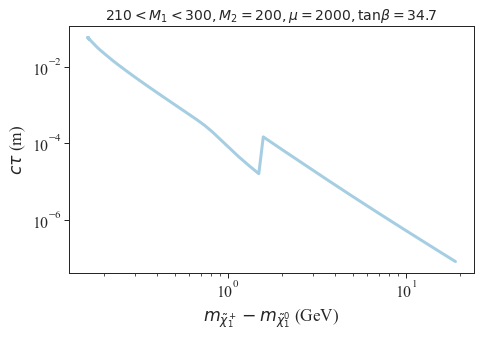

In [6]:
fig = plt.figure(figsize=(7,5))
plt.plot((mC1-mN1)[(mC1-mN1).argsort()],ctau[(mC1-mN1).argsort()],linewidth=3)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$m_{\tilde{\chi}_1^+}-m_{\tilde{\chi}_1^0}$ (GeV)')
plt.ylabel(r'$c \tau$ (m)')
plt.title(r'$%1.0f < M_1 < %1.0f,M_2 = %1.0f, \mu = %1.0f, \tan\beta = %1.1f$' %(M1.min(),M1.max(),M2[0],mu[0],tanb[0]),
          fontsize=14)
plt.tight_layout()
plt.savefig('winoLifetime.png')
plt.show()

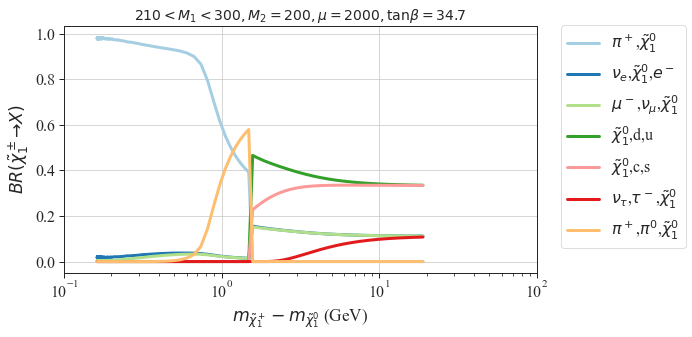

In [7]:
fig = plt.figure(figsize=(10,5))
for fs in decaysDictC1:
    plt.plot((mC1-mN1)[(mC1-mN1).argsort()],decaysDictC1[fs][(mC1-mN1).argsort()],label=fs,linewidth=3)
#     plt.scatter((mC1-mN1)[(mC1-mN1).argsort()],decaysDictC1[fs][(mC1-mN1).argsort()])
    
# plt.vlines(x=1.5,ymin=0,ymax=1,linewidth=1,alpha=0.6,color='gray',label=r'$\Lambda_{had}$')
plt.xlabel(r'$m_{\tilde{\chi}_1^+}-m_{\tilde{\chi}_1^0}$ (GeV)')
plt.ylabel(r'$BR(\tilde{\chi}_1^\pm \to X)$')
plt.legend(loc=(1.05,0.1))
plt.xlim(0.1,100)
plt.xscale('log')
# plt.xticks([0.2,0.5,1,1.5,2,5,80])
plt.grid()
plt.title(r'$%1.0f < M_1 < %1.0f,M_2 = %1.0f, \mu = %1.0f, \tan\beta = %1.1f$' %(M1.min(),M1.max(),M2[0],mu[0],tanb[0]),
          fontsize=14)
plt.tight_layout()
plt.savefig('winoDecays.png')
plt.show()

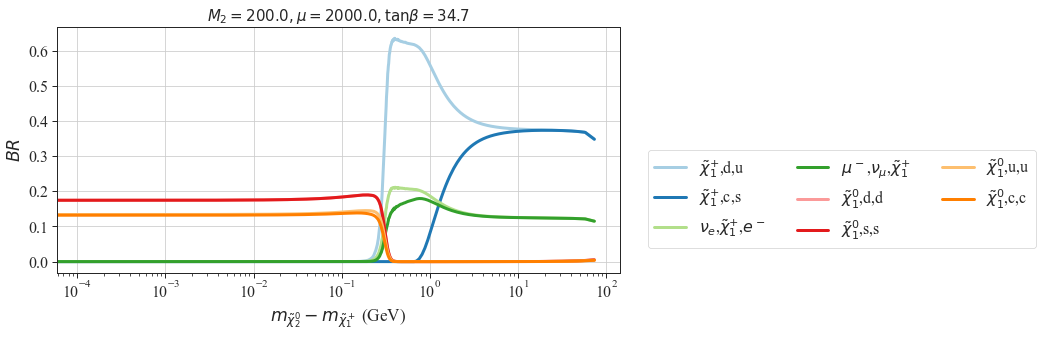

In [8]:
fig = plt.figure(figsize=(15,5))
for fs in decaysDictN2:
    if max(decaysDictN2[fs]) < 0.1: continue
    plt.plot((mN2-mC1)[(mN2-mC1).argsort()],decaysDictN2[fs][(mN2-mC1).argsort()],label=fs,linewidth=3)
plt.xlabel(r'$m_{\tilde{\chi}_2^0}-m_{\tilde{\chi}_1^+}$ (GeV)')
plt.ylabel(r'$BR$')
plt.legend(loc=(1.05,0.1),ncol=3)
# plt.xlim(0.1,40)
plt.xscale('log')
# plt.xticks([0.2,0.5,1,1.5,2,5,80])
plt.grid()
plt.title(r'$M_2 = %1.1f, \mu = %1.1f, \tan\beta = %1.1f$' %(M2[0],mu[0],tanb[0]),fontsize=15)
plt.tight_layout()
plt.show()